## Importing Important Liraries

In [1]:
import os
import tarfile
import urllib.request
import tensorflow as tf

print (tf. __version__ )


2025-04-28 20:43:57.418705: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745873037.662968      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745873037.739037      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.18.0


## Downloading the Stack Overflow Dataset

In [2]:
tar_path = '/kaggle/input/stack-overflow/stack_overflow_16k.tar.gz'




In [3]:
import os
print(os.listdir('/kaggle/working'))

['__notebook__.ipynb']


In [4]:
# Path where your uploaded file is located
stack_overflow_tar = '/kaggle/working/stack_overflow_16k.tar.gz'

# 1. Extract the tar.gz file if not already extracted
if not os.path.exists('/kaggle/input/stack-overflow'):
    with tarfile.open(stack_overflow_tar, 'r:gz') as tar:
        tar.extractall(path='/kaggle/working/')
    print("Extraction complete!")
else:
    print("Already extracted.")

Already extracted.


stack_overflow/
 ├── train/
 │    ├── python/
 │    ├── javascript/
 │    ├── java/
 │    └── csharp/
 └── test/


## Preparing the dataset

In [5]:
# 2. Set batch size and seed
batch_size = 32
seed = 42

# 3. Create training, validation, and test datasets
train_ds = tf.keras.utils.text_dataset_from_directory(
    '/kaggle/input/stack-overflow/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed
)

val_ds = tf.keras.utils.text_dataset_from_directory(
    '/kaggle/input/stack-overflow/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

test_ds = tf.keras.utils.text_dataset_from_directory(
    '/kaggle/input/stack-overflow/test',
    batch_size=batch_size
)

print("Datasets prepared successfully!")

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


2025-04-28 20:44:16.728075: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 8000 files belonging to 4 classes.
Using 1600 files for validation.
Found 8000 files belonging to 4 classes.
Datasets prepared successfully!


# Updating the Model Architecture


In [6]:
from tensorflow.keras import layers

# Create a text vectorization layer
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (without labels) for adapt()
train_text = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

# Build the model
model = tf.keras.Sequential([
    vectorize_layer,
    layers.Embedding(max_features + 1, 16),
    layers.Dropout(0.2),
    layers.GlobalAveragePooling1D(),
    layers.Dropout(0.2),
    layers.Dense(4)  
])

# Model Compilation

updating the model loss function and metrics

In [7]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer='adam',
    metrics=['accuracy'])  # Changed from BinaryAccuracy to accuracy

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ ?                           │     0 (unbuilt) │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ ?                           │     0 (unbuilt) │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Training the model

The output will reflect multi-class metrics

In [9]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs,
    callbacks=[early_stopping]
)


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - accuracy: 0.3028 - loss: 1.3793 - val_accuracy: 0.3681 - val_loss: 1.3558
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.4039 - loss: 1.3414 - val_accuracy: 0.4656 - val_loss: 1.3035
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4893 - loss: 1.2838 - val_accuracy: 0.5362 - val_loss: 1.2292
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.5494 - loss: 1.2083 - val_accuracy: 0.6350 - val_loss: 1.1376
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6131 - loss: 1.1177 - val_accuracy: 0.7056 - val_loss: 1.0558
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6643 - loss: 1.0316 - val_accuracy: 0.6831 - val_loss: 0.9757
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6938 - loss: 0.9589 - val_accuracy: 0.7331 - val_loss: 0.9109
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7230 - loss: 0.8905 - val_accu

# Evaluating the model

In [10]:
test_loss, test_acc = model.evaluate(test_ds)

print("\n Test Loss: ", test_loss)
print("\n Test Accuracy: ", test_acc)

250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.7299 - loss: 0.8014

 Test Loss:  0.8034055233001709

 Test Accuracy:  0.734250009059906


# Creating a plot of accuracy and loss over time

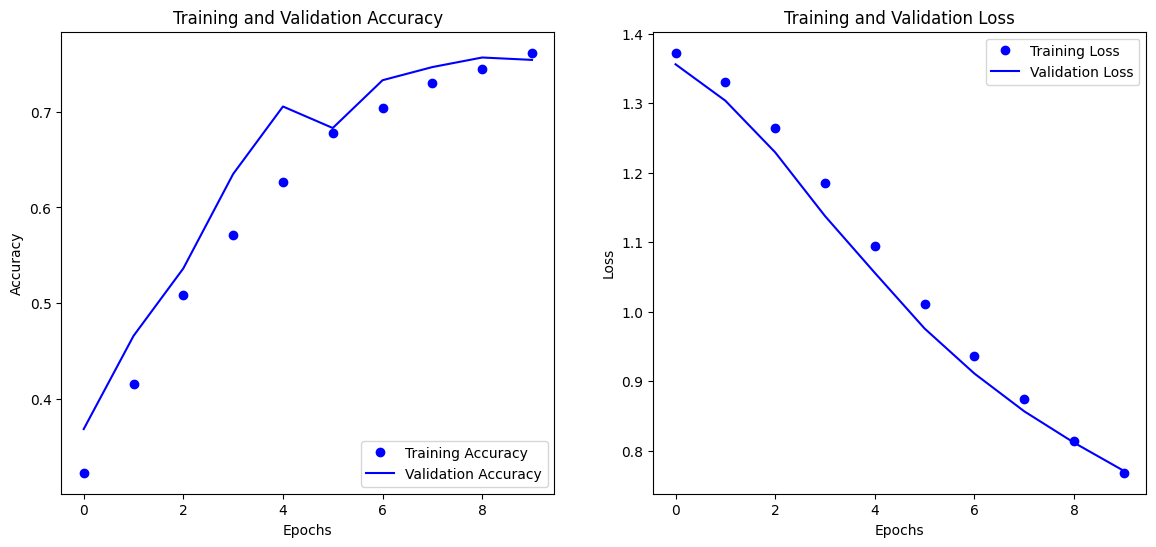

In [11]:
import matplotlib.pyplot as plt

#Extract history values
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plotting the curves
plt.figure(figsize=(14,6))

#Accuracy plot
plt.subplot(1, 2, 1)
# "bo" is for "blue dot"
plt.plot(epochs_range, acc, 'bo', label='Training Accuracy')
# "b" is for "blue dot"
plt.plot(epochs_range, val_acc, 'b', label='Validation Accuracy') 
plt.legend(loc='lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
# "bo" is for "blue dot"
plt.plot(epochs_range, loss, 'bo', label='Training Loss')
# "b" is for "blue dot"
plt.plot(epochs_range, val_loss, 'b', label='Validation Loss') 
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.show()

# Accuracy Curves
The accuracy curves, both training and validation, generally exhibit an upward trend over epochs. This indicates that the model is learning and improving its performance on the training and validation datasets.

# Training Accuracy: 
Usually increases steadily, and may approach very high values (close to 1.0) as training progresses. This reflects the model's increasing ability to correctly classify the training data it has seen repeatedly.

# Validation Accuracy: 
Ideally increases alongside training accuracy, but typically at a slightly slower rate and might plateau earlier. This shows how well the model generalizes to unseen data (validation set). If the validation accuracy stagnates or starts to decrease while the training accuracy keeps increasing, it suggests overfitting.
# Loss Curves
The loss curves, both training and validation, generally exhibit a downward trend over epochs. This indicates that the model is minimizing the errors it makes during training and validation.

# Training Loss: 
Usually decreases steadily as the model learns to make better predictions on the training data.
# Validation Loss: 
Ideally decreases alongside training loss, but may start to increase or plateau at some point. This is a key indicator for overfitting - when the model starts to memorize the training data instead of learning general patterns.
# Overfitting and Ideal Shapes
Ideally, we want both the training and validation curves to improve and converge. This indicates a well-generalizing model.

**Overfitting** is observed when the training accuracy/loss continues to improve while the validation accuracy/loss stagnates or worsens. This means the model is becoming too specialized to the training data and performs poorly on unseen data. The validation curves would show a flattening or even an upward trend (for loss) or a downward trend (for accuracy) after a certain number of epochs.